### Model 10 settings:

We drop 'half-true' datas and combine classes to 2 classes.

We did TFIDF on data for machine learning models.

We did Word2Vec on data for deep learning models.

Then we have full preproccesing on data.

Stacking is by binary prediction of models.

Embedding dim is 150


In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_fscore_support
import Scripts.Data_Read_Prepare as Data_Prepare
import Scripts.Fake_News_Detection_SVM as SVM_classifier
import Scripts.Fake_News_Detection_PA as PA_classifier
import Scripts.Fake_News_Detection_XGBoost as XGBoost_classifier
import Scripts.Fake_News_Detection_LSTM as LSTM_classifier
import Scripts.Fake_News_Detection_BiLSTM as BiLSTM_classifier
import Scripts.Fake_News_Detection_Stacked_MLP as MLP_classifier

Loading data from datasets

In [2]:
data_train, data_valid, data_test = Data_Prepare.read_data()
data_train.head(3)

0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   

         6           7     8     9      10     11   12               13  
0     Texas  republican   0.0   1.0    0.0    0.0  0.0         a mailer  
1  Virginia    democrat   0.0   0.0    1.0    1.0  0.0  a floor speech.  
2  Illinois    democrat  70.0  71.0  160.0  163.0  9.0           Denver

In [3]:
data_train = Data_Prepare.combine_classes_drop_half_true(data_train)
data_valid = Data_Prepare.combine_classes_drop_half_true(data_valid)
data_test = Data_Prepare.combine_classes_drop_half_true(data_test)
data_train.head(3)

label                                           sentence
0      0  abortion dwayne-bohac State representative a m...
1      1  foreign-policy barack-obama President Denver H...
2      0  health-care blog-posting nan a news release He...

In [4]:
data_test['label'].value_counts()

0    553
1    449
Name: label, dtype: int64

Preproccesing

In [5]:
data_train1, data_valid1, data_test1 = Data_Prepare.do_preprocessing(data_train, data_valid, data_test)

data_preprocessing done!


In [6]:
data_train2, data_valid2, data_test2 = Data_Prepare.do_preprocessing(data_train, data_valid, data_test)

data_preprocessing done!


In [7]:
data_train['label'].value_counts(normalize='true')

0    0.552301
1    0.447699
Name: label, dtype: float64

In [8]:
# Combine the training and validation datasets for training
data_set_all1 = pd.concat([data_train1, data_valid1, data_test1])
data_train_valid1 = pd.concat([data_train1, data_valid1])

X_train_valid1 = data_train_valid1['sentence']
y_train_valid1 = data_train_valid1['label']
X_test1 = data_test['sentence']
y_test1 = data_test['label']

In [10]:
# Combine the training and validation datasets for training
data_set_all2 = pd.concat([data_train2, data_valid2, data_test2])
data_train_valid2 = pd.concat([data_train2, data_valid2])

X_train_valid2 = data_train_valid2['sentence']
y_train_valid2 = data_train_valid2['label']
X_test2 = data_test['sentence']
y_test2 = data_test['label']

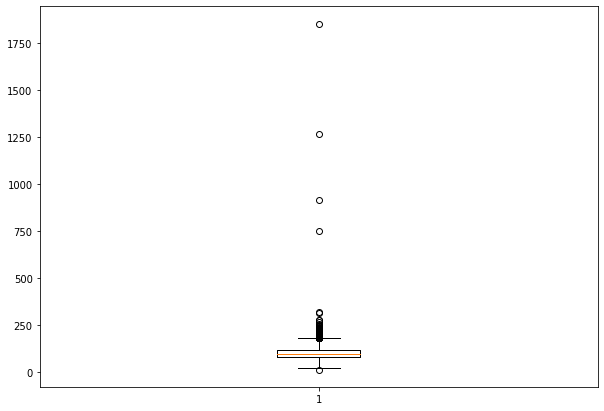

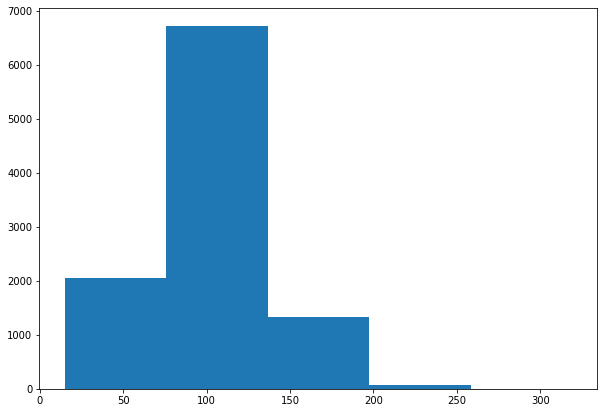

In [102]:
Data_Prepare.plot_data_length(data_set_all)

Vectorizing

In [24]:
# For Cross Validation
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_set_all1['sentence'])



In [76]:
#For cross calidation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_set_all2['sentence'])
    
# Convert text to sequences
X_cross = tokenizer.texts_to_sequences(data_set_all2['sentence'])
    
# Pad sequences
X_cross = pad_sequences(X_cross, maxlen=260)
    

In [11]:
X_train_t_v1, X_test_t_v1, vocab_size1, X_train_sequences, X_test_sequences=Data_Prepare.tfidf_vectorizer(X_train_valid1,
                                                                                                          X_test1,
                                                                                                          MAX_SEQUENCE_LENGTH=260,EMBEDDING_DIM=150)

Vectorizing done!


In [12]:
embedding_matrix,X_train_t_v2, y_train_t_v2, X_test_t_v2, y_test_t_v2, vocab_size2 = Data_Prepare.tokenize_vectorize(data_set_all2,
                                                                                                                data_train_valid2,
                                                                                                                data_test2,
                                                                                                                MAX_SEQUENCE_LENGTH=260
                                                                                                                ,EMBEDDING_DIM=150)

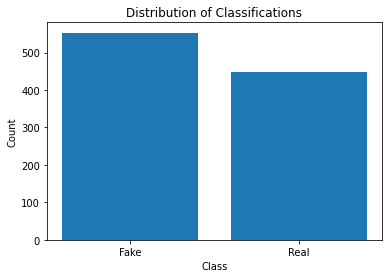

In [122]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_test)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 1- SVM

In [51]:
svm_predictions, svm_train_valid_predictions =SVM_classifier.train_svm(X_train_t_v1, y_train_valid1, X_test_t_v1)

Execution time of SVM: 33.51 seconds


SVM - accuracy: 0.5868263473053892
SVM - Precision: 0.5381263616557734
SVM - Recall: 0.5501113585746102
SVM - F-score: 0.5440528634361234


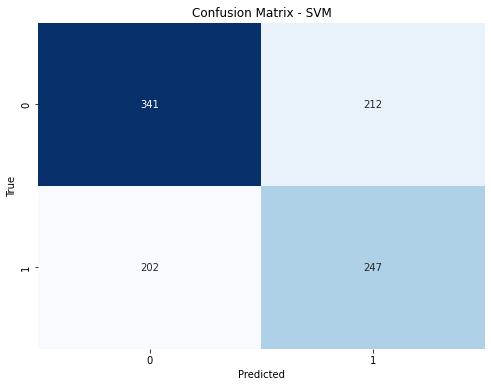

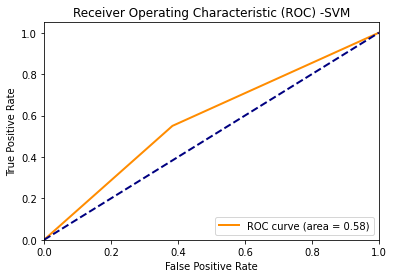

In [15]:
svm_accuracy, svm_precision, svm_recall, svm_fscore = SVM_classifier.svm_metrics(svm_predictions, y_test1)
SVM_classifier.svm_confusion_matrix_plot(svm_predictions, y_test1)
SVM_classifier.svm_roc_plot(svm_predictions, y_test1)

In [20]:
X_train_t_v1.shape

(9162, 8243)

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, StratifiedKFold
def cross_validate_svm(X, y, svm_params, cv_splits=5):
    
    # Define SVM parameters
#     svm_params = {'C': 10, 'kernel': 'sigmoid', 'gamma': 'scale'}

    svm_model = SVC(**svm_params)
    
    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
    }
    scores = cross_validate(svm_model, X, y, cv=5, scoring=scoring)
    print(scores.keys())
    print(np.mean(scores['test_accuracy']))
    print(np.mean(scores['test_precision'])) 
    print(np.mean(scores['test_recall']))
    print(np.mean(scores['test_f1']))



svm_params = {'C': 10, 'kernel': 'sigmoid', 'gamma': 'scale'}
svm_cross_x = tfidf_matrix
svm_cross_y = data_set_all1['label']
cross_validate_svm(svm_cross_x, svm_cross_y, svm_params, cv_splits=5)

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])
0.5991737221669229
0.5492450022656978
0.5376110800760918
0.5431870128384698


## 2-Passive Aggressive

In [52]:
pa_predictions,pa_train_valid_predictions, pa_scores, pa_train_scores = PA_classifier.train_pa(X_train_t_v1,
                                                                                               y_train_valid1,
                                                                                               X_test_t_v1,
                                                                                               c = 0.1,
                                                                                               iteration=100, tol=1e-1)

Execution time of PA: 0.03 seconds


PA - accuracy: 0.6307385229540918
PA - Precision: 0.5985037406483791
PA - Recall: 0.534521158129176
PA - F-score: 0.5647058823529412


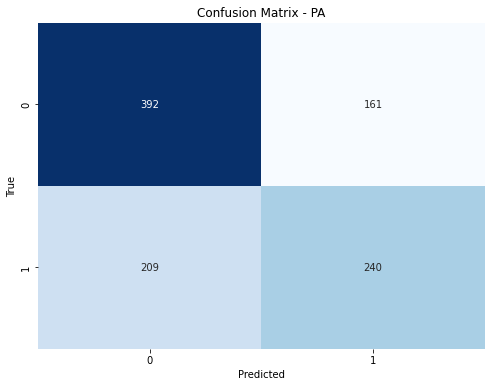

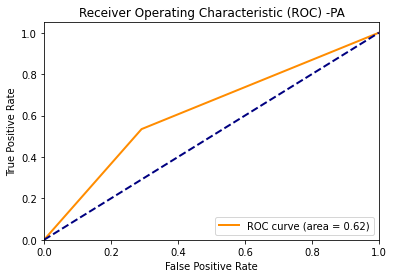

In [17]:
pa_accuracy, pa_precision, pa_recall, pa_fscore = PA_classifier.pa_metrics(pa_predictions, y_test1)
PA_classifier.pa_confusion_matrix_plot(pa_predictions, y_test1)
PA_classifier.pa_roc_plot(pa_predictions, y_test1)

In [32]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import PassiveAggressiveClassifier

def pa_cross_validation(X, y,k_folds=5,c = 0.1,iteration=100, tol=1e-1):
    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
    }
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    pa_model = PassiveAggressiveClassifier(C=c, random_state=42, max_iter=iteration, early_stopping=True, tol=tol)
    scores = cross_validate(pa_model, X, y, cv=kf, scoring=scoring)
    print(scores.keys())
    print(np.mean(scores['test_accuracy']))
    print(np.mean(scores['test_precision'])) 
    print(np.mean(scores['test_recall']))
    print(np.mean(scores['test_f1']))
    
pa_cross_x = tfidf_matrix
pa_cross_y = data_set_all1['label']
pa_cross_validation(pa_cross_x, pa_cross_y)

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])
0.6253438346030652
0.5862647749400212
0.5274536258621961
0.5548895214573506


## 3-XGBoost

In [53]:
xgb_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.2  # subsample ratio of columns when constructing each tree
}

xgb_predictions, xgb_train_valid_predictions, xgb_scores, xgb_train_scores = XGBoost_classifier.train_xgboost(X_train_t_v1,
                                                                                                              y_train_valid1,
                                                                                                              X_test_t_v1,y_test1,
                                                                                                              xgb_params)

Execution time of XGBoost: 23.76 seconds


XGBoost - accuracy: 0.6137724550898204
XGBoost - Precision: 0.5453216374269005
XGBoost - Recall: 0.8307349665924276
XGBoost - F-score: 0.6584289496910857


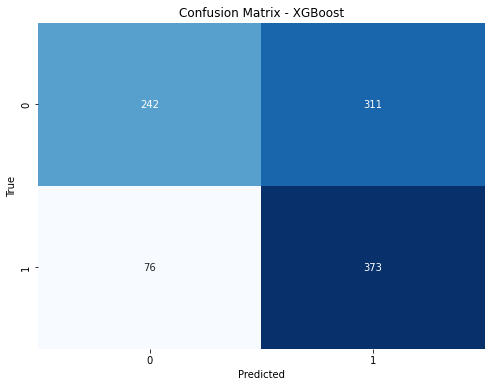

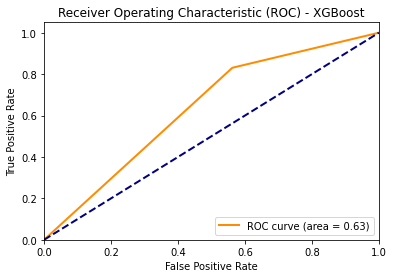

In [19]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test1)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test1)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test1)

In [46]:
xgb_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.2  # subsample ratio of columns when constructing each tree
}

xgb_predictions, xgb_train_valid_predictions, xgb_scores, xgb_train_scores = XGBoost_classifier.train_xgboost(X_train_t_v1,
                                                                                                              y_train_valid1,
                                                                                                              X_test_t_v1,y_test1,
                                                                                                              xgb_params)

xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test1)


Execution time of XGBoost: 24.02 seconds
XGBoost - accuracy: 0.6137724550898204
XGBoost - Precision: 0.5453216374269005
XGBoost - Recall: 0.8307349665924276
XGBoost - F-score: 0.6584289496910857


In [50]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

xgb_cross_x = tfidf_matrix
xgb_cross_y = data_set_all1['label']
data_dmatrix_cross = xgb.DMatrix(data=xgb_cross_x, label=xgb_cross_y)

# Custom evaluation metrics
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'f1_score', f1_score(y_true, y_pred)

def precision_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'precision', precision_score(y_true, y_pred)

def recall_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'recall', recall_score(y_true, y_pred)

xgb_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.2  # subsample ratio of columns when constructing each tree
}

evals_result = xgb.cv(xgb_params, data_dmatrix_cross, num_boost_round=50, nfold=5, early_stopping_rounds=10, 
                      custom_metric=f1_eval, 
                      seed=42, as_pandas=True)

print(evals_result)

   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std  \
0            0.686266             0.0006           0.686579           0.00227   

   train-f1_score-mean  train-f1_score-std  test-f1_score-mean  \
0             0.614405             0.00241            0.614342   

   test-f1_score-std  
0           0.009654  


## 4-LSTM

In [20]:
print(vocab_size2)

8636


In [54]:
lstm_model, lstm_history = LSTM_classifier.train_lstm(vocab_size2,
                                                      embedding_matrix,
                                                      X_train_t_v2,
                                                      y_train_t_v2,
                                                      epoches=10,
                                                      batch_size=128,
                                                      MAX_SEQUENCE_LENGTH=260,
                                                      EMBEDDING_DIM=150)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 260, 150)          1295400   
                                                                 
 lstm_layer1 (LSTM)          (None, 260, 128)          142848    
                                                                 
 lstm_layer2 (LSTM)          (None, 260, 64)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [57]:
lstm_train_valid_predictions, lstm_predictions, lstm_train_scores, lstm_scores = LSTM_classifier.predict_lstm(lstm_model,
                                                                              X_train_t_v2,
                                                                              X_test_t_v2,
                                                                             0.4)

287/287 [==============================] - 37s 129ms/step


LSTM - Accuracy: 0.5658682634730539
LSTM - Precision: 0.5100574712643678
LSTM - Recall: 0.7906458797327395
LSTM - F-score: 0.6200873362445415


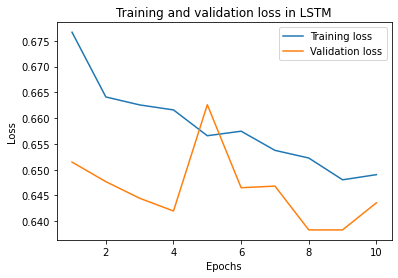

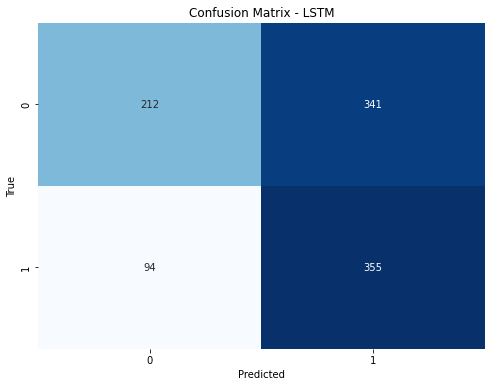

In [23]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore = LSTM_classifier.lstm_metrics(lstm_predictions, y_test_t_v2)
LSTM_classifier.lstm_loss_plot(lstm_history)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v2)

## 5-BiLSTM

In [55]:
bilstm_model, bilstm_history = BiLSTM_classifier.train_bilstm(vocab_size2,
                                                              X_train_t_v2,
                                                              y_train_t_v2, 10,64,
                                                              MAX_SEQUENCE_LENGTH = 260,
                                                              EMBEDDING_DIM = 150)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 260, 150)          1295400   
                                                                 
 bidirectional (Bidirectiona  (None, 260, 256)         285696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,749,609
Trainable params: 454,209
Non-

In [58]:
bilstm_train_predictions, bilstm_predictions, bilstm_train_scores,bilstm_scores = BiLSTM_classifier.predict_bilstm(bilstm_model,
                                                                                X_train_t_v2, X_test_t_v2, 0.4)

287/287 [==============================] - 88s 305ms/step


287/287 [==============================] - 74s 257ms/step
BiLSTM - Accuracy: 0.5349301397205589
BiLSTM - Precision: 0.489171974522293
BiLSTM - Recall: 0.8552338530066815
BiLSTM - F-score: 0.6223662884927067


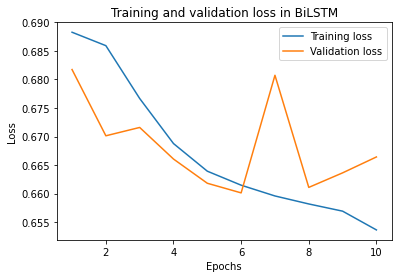

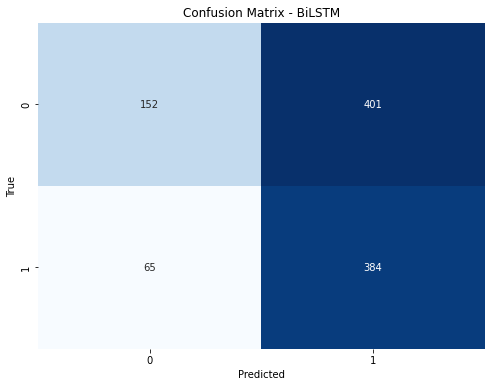

In [25]:
bilstm_train_predictions, bilstm_predictions, bilstm_train_scores,bilstm_scores = BiLSTM_classifier.predict_bilstm(bilstm_model,
                                                                                X_train_t_v2, X_test_t_v2, 0.4)
bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore=BiLSTM_classifier.bilstm_metrics(bilstm_predictions, y_test_t_v2)
BiLSTM_classifier.bilstm_loss_plot(bilstm_history)
BiLSTM_classifier.bilstm_confusion_matrix_plot(bilstm_predictions, y_test_t_v2)

## Evaluate Ensemblely!

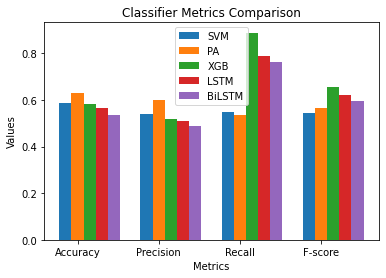

In [46]:
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [svm_accuracy, svm_precision, svm_recall, svm_fscore] 
pa=[pa_accuracy, pa_precision, pa_recall, pa_fscore]
xgb=[xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore]
lstm = [lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore] 
bilstm = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore] 

bar_width = 0.15 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, pa, bar_width, label='PA')
plt.bar(index + 2*bar_width, xgb, bar_width, label='XGB')
plt.bar(index + 3*bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 4*bar_width, bilstm, bar_width, label='BiLSTM')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

#### Voting Test predictions

In [49]:
import numpy as np
def ensemble_prediction():   
    votes = np.array([list(row) for row in zip(svm_predictions ,xgb_predictions, pa_predictions, lstm_predictions, bilstm_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [50]:
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test1) / len(y_test1)

precision, recall, fscore, support = precision_recall_fscore_support(y_test1, y_pred_ensemble, average='binary')
print("Model - accuracy:", accuracy)
print("Model - Precision:", precision)
print("Model - Recall:", recall)
print("Model - F-score:", fscore)

Model - accuracy: 0.6107784431137725
Model - Precision: 0.5490848585690515
Model - Recall: 0.734966592427617
Model - F-score: 0.6285714285714286


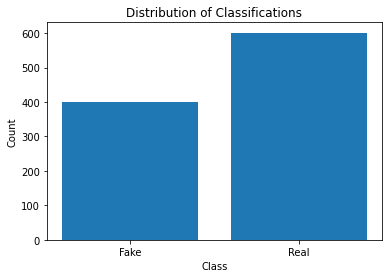

In [51]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### Voting train predictions

In [32]:
import numpy as np
def ensemble_train_prediction():   
    votes = np.array([list(row) for row in zip(svm_train_valid_predictions ,
                                               xgb_train_valid_predictions,
                                               pa_train_valid_predictions,
                                               lstm_train_valid_predictions,
                                               bilstm_train_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [33]:
y_train_valid_pred_ensemble = ensemble_train_prediction()

train_accuracy = sum(y_train_valid_pred_ensemble == y_train_valid1) / len(y_train_valid1)

train_precision, train_recall, train_fscore, train_support = precision_recall_fscore_support(y_train_valid1, y_train_valid_pred_ensemble, average='binary')
print("Model - accuracy:", train_accuracy)
print("Model - Precision:", train_precision)
print("Model - Recall:", train_recall)
print("Model - F-score:", train_fscore)

Model - accuracy: 0.6900240122244051
Model - Precision: 0.6107675518370317
Model - Recall: 0.8275012321340561
Model - F-score: 0.7028045207199665


## FinalClassifier

XGBoost Stacked

In [59]:
xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_t_v2, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             bilstm_train_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v2, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))
                           ))


XGBoost - accuracy: 0.5808383233532934
XGBoost - Precision: 0.5188556566970091
XGBoost - Recall: 0.888641425389755
XGBoost - F-score: 0.6551724137931034


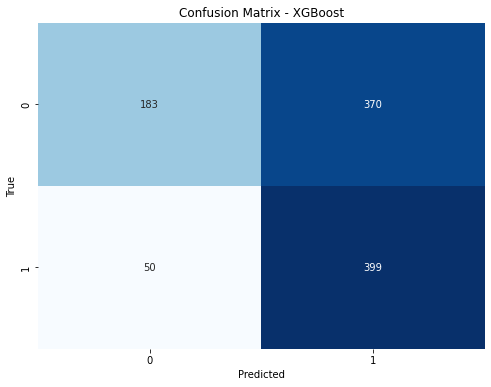

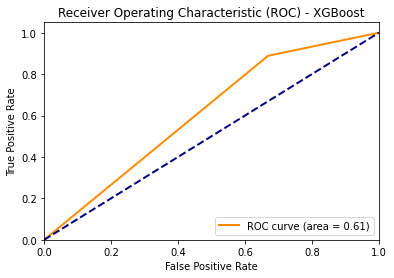

In [42]:
xgb_final_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth':2,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
}

xgb_predictions_stack3, bla1,y1,y2 = XGBoost_classifier.train_xgboost(stacked_X_train,y_train_valid1,
                                                                     stacked_X_test,y_test1,
                                                                     xgb_final_params,
                                                                     rounds=20, threshold=0.4)

xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions_stack3, y_test1)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions_stack3, y_test1)
XGBoost_classifier.xgb_roc_plot(xgb_predictions_stack3, y_test2)

In [ ]:
xgb_final_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth':2,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
}

xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_t_v2, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             bilstm_train_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v2, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))
                           ))

xgb_predictions_stack3, bla1,y1,y2 = XGBoost_classifier.train_xgboost(stacked_X_train,y_train_valid1,
                                                                     stacked_X_test,y_test1,
                                                                     xgb_final_params,
                                                                     rounds=20, threshold=0.4)

xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions_stack3, y_test1)

In [75]:
svm_train_valid_predictions.shape

(9162,)

In [87]:
svm_predictions_all = np.vstack((svm_train_valid_predictions.reshape((-1, 1)),
                                 svm_predictions.reshape((-1, 1))
                                ))
xgb_predictions_all = np.vstack((xgb_train_valid_predictions.reshape((-1, 1)),
                                 xgb_predictions.reshape((-1, 1))
                                ))
pa_predictions_all = np.vstack((pa_train_valid_predictions.reshape((-1, 1)),
                                 pa_predictions.reshape((-1, 1))
                                ))
lstm_predictions_all = np.vstack((lstm_train_valid_predictions.reshape((-1, 1)),
                                 lstm_predictions.reshape((-1, 1))
                                ))
bilstm_predictions_all = np.vstack((bilstm_train_predictions.reshape((-1, 1)),
                                 bilstm_predictions.reshape((-1, 1))
                                ))

In [93]:
stacked_X_cross = np.hstack((X_cross,
                             svm_predictions_all,
                             xgb_predictions_all,
                             pa_predictions_all,
                             lstm_predictions_all,
                             bilstm_predictions_all
                            ))

In [ ]:
stacked_y_Cross = np.hstack((data_set_all2['label'], ))

In [94]:
stacked_X_cross.shape

(10164, 265)

In [123]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

data_dmatrix_final_cross = xgb.DMatrix(data=stacked_X_cross, label=data_set_all2['label'])

# Custom evaluation metrics
def accuracy_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'accuracy', accuracy_score(y_true, y_pred)

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'f1_score', f1_score(y_true, y_pred)

def precision_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'precision', precision_score(y_true, y_pred)

def recall_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred >= 0.4).astype(int)  # Assuming binary classification
    return 'recall', recall_score(y_true, y_pred)

xgb_final_params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth':2,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
}


evals_result = xgb.cv(xgb_final_params, data_dmatrix_final_cross, num_boost_round=20, nfold=5,
                      early_stopping_rounds=20,
                      custom_metric=accuracy_eval, 
                      seed=0, as_pandas=True)

print(evals_result)

    train-logloss-mean  train-logloss-std  test-logloss-mean  \
0             0.684271           0.000413           0.684332   
1             0.681969           0.000417           0.682049   
2             0.679337           0.000417           0.679408   
3             0.677017           0.000351           0.677069   
4             0.674945           0.000364           0.675011   
5             0.674022           0.000344           0.674100   
6             0.672239           0.000322           0.672328   
7             0.669853           0.000326           0.669942   
8             0.667406           0.000326           0.667509   
9             0.665750           0.000390           0.665866   
10            0.663409           0.000428           0.663536   
11            0.661425           0.000471           0.661567   
12            0.659460           0.000533           0.659605   
13            0.657453           0.000440           0.657600   
14            0.655274           0.00041